# Preconditioning

Preconditioning is a simple, general idea that can require a lot of explanation in practice. Since the convergence of a Krylov method depends (at least) on the spectral properties of the matrix, we can improve the convergence by transforming to an equivalent problem with a different matrix. Specifically, $Ax=b$ becomes $M^{-1}Ax=M^{-1}b$ for some matrix $M$. The idea is to choose $M \approx A$ in some sense, so that $M^{-1}A$ is more like an identity matrix, which is easy to solve for.

As usual, though, we don't want to work with $M^{-1}$ literally. Instead, the crucial Arnoldi step of computing $v=Aq$ becomes a 2-step process: set $w=Aq$, then solve $Mv=w$ for $v$. So in addition to $M\approx A$, we also want the preconditioner to be "easily inverted," meaning that it's easy to solve arbitrary linear systems with $M$ as the matrix. Software usually gives you a choice of providing either a matrix $M$ (which is then factored internally), or a function that computes $M^{-1}w$ for any given $w$. 

For an SPD $A$, typically you would want $M$ to be SPD as well. If $M=R^TR$ is a Cholesky factorization, then the correct preconditioning form is

$$ R^{-T}AR^{-1}u = R^{-T}b, \quad x = R^{-1}u.$$

The preconditioned matrix of this problem is also SPD. 

## Algebraic preconditioners

There is a large family of preconditioners that are derived essentially from algebraic manipulations of the matrix itself. For illustration, we will use the 5-point difference representation of the Laplacian operator on a square to solve $\Delta u = -1$.

In [1]:
using LinearAlgebra, SparseArrays, PyPlot, IterativeSolvers

In [2]:
D2(n) = (n-1)^2*spdiagm( -1=>-ones(n-3), 0=>2*ones(n-2), 1=>-ones(n-3) )
speye(n) = spdiagm(0=>ones(n))
del2(n) = kron(speye(n-2),D2(n)) + kron(D2(n),speye(n-2));
Matrix(del2(5))

9×9 Array{Float64,2}:
  64.0  -16.0    0.0  -16.0    0.0    0.0    0.0    0.0    0.0
 -16.0   64.0  -16.0    0.0  -16.0    0.0    0.0    0.0    0.0
   0.0  -16.0   64.0    0.0    0.0  -16.0    0.0    0.0    0.0
 -16.0    0.0    0.0   64.0  -16.0    0.0  -16.0    0.0    0.0
   0.0  -16.0    0.0  -16.0   64.0  -16.0    0.0  -16.0    0.0
   0.0    0.0  -16.0    0.0  -16.0   64.0    0.0    0.0  -16.0
   0.0    0.0    0.0  -16.0    0.0    0.0   64.0  -16.0    0.0
   0.0    0.0    0.0    0.0  -16.0    0.0  -16.0   64.0  -16.0
   0.0    0.0    0.0    0.0    0.0  -16.0    0.0  -16.0   64.0

As is usually the case in PDEs, the conditioning of $A$ gets worse as the discretization gets better. (After all, the eigenvalues of the exact operator are unbounded.) 

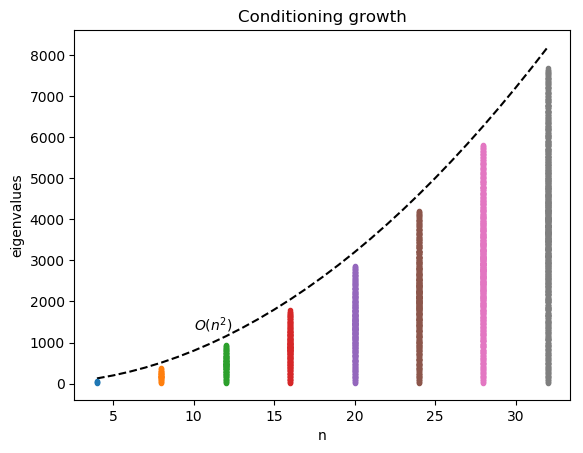

In [3]:
plot(4:32,8*(4:32).^2,"k--")
for n = 4:4:32
    lambda = eigvals( Matrix(del2(n)) );
    plot(fill(n,length(lambda)),lambda,".")
end

text(10,1300,L"O(n^2)");
title("Conditioning growth");
xlabel("n");
ylabel("eigenvalues");

Without preconditioning, this system is already fairly challenging at $n=120$. 

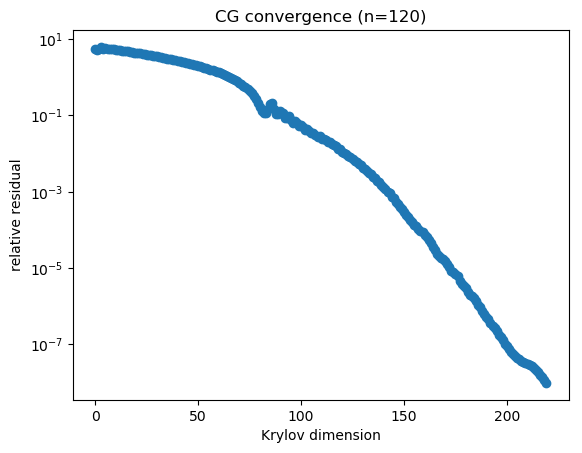

In [4]:
n = 120;
A = del2(n);  b = -ones(size(A,1));  
x,his = cg(A,b,tol=1e-8,maxiter=250,log=true);
semilogy(his[:resnorm]/norm(b),"o-");
xlabel("Krylov dimension")
ylabel("relative residual")
title("CG convergence (n=120)");

(Here's a peek at the solution on the square.)

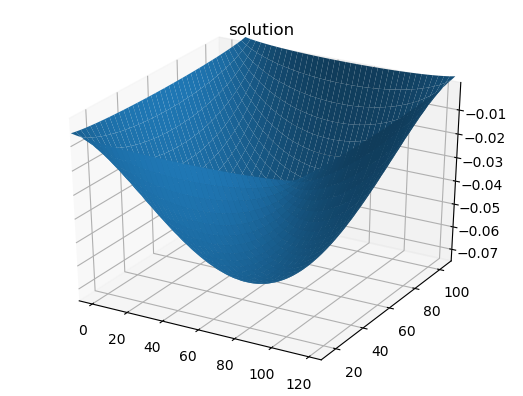

In [5]:
surf( reshape(x,n-2,n-2) )
axis("equal")
title("solution");

We can now go all the way back to the splitting idea of Jacobi and Gauss-Seidel. If $A=M-N$, then that iteration is $x_{n+1}=M^{-1}Nx_n + M^{-1}b$. If this converges, then you have really solved $(I-M^{-1}N)x = M^{-1}Ax=M^{-1}b$! So we can view these as brain-dead iterations for a problem with preconditioner $M$. Replace the brain-dead iteration with GMRES or similar, and maybe we will get somewhere. 

In [6]:
struct JacobiPrec
    d  # diagonal entries
    JacobiPrec(A::AbstractArray) = new(diag(A))
end
import LinearAlgebra: ldiv!, \
function ldiv!(y, P::JacobiPrec, x) 
    copyto!(y,x./P.d)
end
function ldiv!(P::JacobiPrec, x) 
    x ./= P.d
end
\(P::JacobiPrec,x) = x./P.d

\ (generic function with 154 methods)

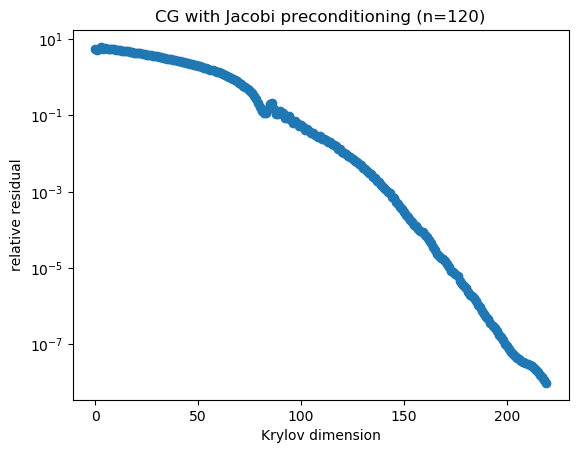

In [19]:
n = 120;
A = del2(n);  b = -ones(size(A,1));  
M = JacobiPrec(A)
x,his = cg(A,b,Pl=M,tol=1e-8,maxiter=250,log=true);
semilogy(his[:resnorm]/norm(b),"o-");
xlabel("Krylov dimension")
ylabel("relative residual")
title("CG with Jacobi preconditioning (n=120)");

As you can see, this helped...not one bit.

We're not confined to the Jacobi and Gauss-Seidel choices. Suppose we try taking $M$ to be the "tridiagonal part" of $A$. That's cheap to solve for, at least.

In [17]:
struct TridiagPrec
    fact
    TridiagPrec(A::AbstractArray) = new(lu(tril(triu(A,-1),1)))
end
import LinearAlgebra: ldiv!, \
function ldiv!(y, P::TridiagPrec, x) 
    copyto!(y,P.fact\x)
end
ldiv!(P::TridiagPrec, x) = ldiv!(P.fact,x)
\(P::JacobiPrec,x) = P.fact\x

\ (generic function with 154 methods)

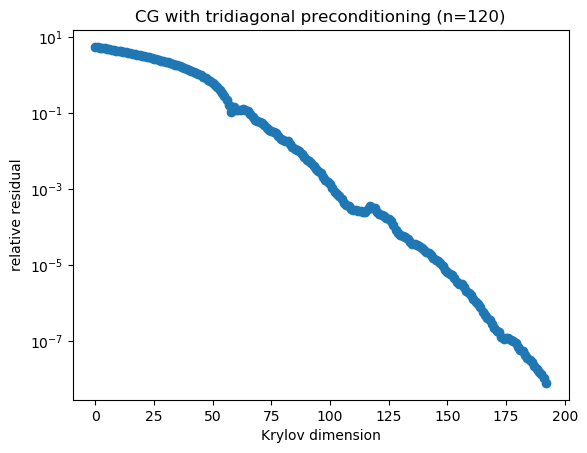

In [20]:
n = 120;
A = del2(n);  b = -ones(size(A,1));  
M = TridiagPrec(A)
x,his = cg(A,b,Pl=M,tol=1e-8,maxiter=250,log=true);
semilogy(his[:resnorm]/norm(b),"o-");
xlabel("Krylov dimension")
ylabel("relative residual")
title("CG with tridiagonal preconditioning (n=120)");

That helped a small amount. It's not easy to make these work without thinking carefully about the details of the matrix.

### Incomplete LU

One reasonably effective family of preconditioners are the *ILU factorizations*. There are different variations, but imagine that while doing an LU factorization you just throw away every value below some threshold. The result is $LU\approx A$ rather than a true factorization, but you are able to maintain sparsity in the factors. 

In [32]:
using IncompleteLU
M = ilu(A,τ=1.)
@show (nnz(A),nnz(M.L),nnz(M.U))

(nnz(A), nnz(M.L), nnz(M.U)) = (69148, 741094, 755018)


(69148, 741094, 755018)

In [33]:
M = ilu(A,τ=0.5)
@show (nnz(A),nnz(M.L),nnz(M.U))

(nnz(A), nnz(M.L), nnz(M.U)) = (69148, 885274, 899198)


(69148, 885274, 899198)

For this problem, ILU works sensationally well.

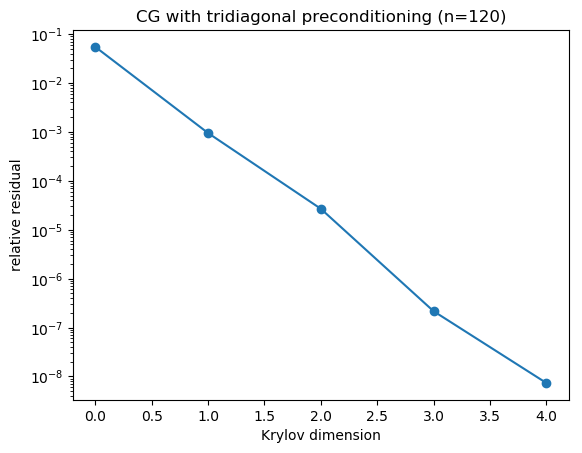

In [34]:
n = 120;
A = del2(n);  b = -ones(size(A,1));  
x,his = cg(A,b,Pl=M,tol=1e-8,maxiter=250,log=true);
semilogy(his[:resnorm]/norm(b),"o-");
xlabel("Krylov dimension")
ylabel("relative residual")
title("CG with tridiagonal preconditioning (n=120)");

A simple preconditioner might be to strip away the nonzeros of $A$ that are wider than the tridiagonal. This $M$ is easier to invert/solve than the original $A$. 

In [31]:
nnz(A)

69148

The strategy helped a little, but note that the asymptotic slope is unchanged; this preconditioner does not slow the growth in the number of iterations with $n$. Good preconditioners can keep the growth much slower, even as low as $O(1)$ for the famous multigrid method. 